In [7]:
#importing required packages
import numpy as np
import re, tarfile, random
from functools import reduce
import keras
from keras.layers import Dense, Merge, Dropout, RepeatVector, Activation, recurrent
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.utils.data_utils import get_file
from keras.callbacks import History
from keras import backend as K

#defining the temperatues for the notes 
def sample(preds, temperature):
    # Helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

#Loading abc notation based music file
data = open('music_abc.txt', 'r').read()
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print ('Unique characters:', chars)
print ('The data has', data_size, 'characters, with', vocab_size, 'unique characters')

#Vectorizing the data for one hot encoding
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }
train_data=data[:int(0.8*data_size)]
val_data = data[int(0.8*data_size):]
seq_len = 25

train_data = [data[i] for i in range(len(data))]
train_data=train_data[:-30]

train_data_onehot = [list(to_categorical(char_to_ix[x],vocab_size)) for x in train_data]

#Loading it to an array
train_data_onehot = np.array(train_data_onehot)




Unique characters: ['X', ':', ')', 'I', 'f', ' ', 's', 'a', 'e', 'u', '~', 'H', '=', 'M', 'k', 'z', 'U', 'O', 'Y', 'R', '\n', '2', '4', 'K', 'w', '+', 'v', 'm', 'N', "'", '5', '8', 'S', '9', 'x', 'b', '"', 'p', 'A', '|', 'i', 'L', 'B', 'n', '^', ',', 'c', 't', '?', 'j', 'Q', 'd', '/', '#', ']', '6', '!', '0', '-', '.', 'G', 'T', 'r', '>', 'D', '3', 'l', 'J', 'q', 'E', 'W', '1', '\\', 'C', 'y', '_', '[', 'o', 'F', 'P', '%', 'g', '&', 'V', '7', '(', 'h']
The data has 134156 characters, with 87 unique characters


In [8]:
print(len(train_data_onehot))

train_data_onehot 
print(len(train_data))

134126
134126


In [23]:
#Reshaping the data for dividing into train, test and validation

training_batches = np.reshape(train_data_onehot[:-1], (int(train_data_onehot.shape[0]/seq_len), seq_len, vocab_size))
print(training_batches.shape)

(5365, 25, 87)


In [33]:
print(y.shape)

(5365, 24, 87)


In [19]:
#Splitting the data

X = training_batches[:,:-1,:]
y = training_batches[:,1:,:]
train_len=int(0.8*training_batches.shape[0])
X_train = X[:train_len,:,:]
y_train = y[:train_len,:,:]
X_valid = X[train_len:,:,:]
y_valid = y[train_len:,:,:]

#Converting to the string
convert2String = lambda y: ''.join([ix_to_char[x[0]] for x in list(np.reshape(np.argmax(y, axis=2), (-1,1)))])

#Defining the model
epochs=50
input_dim = vocab_size
hidden_dim = 100
output_dim = vocab_size
rnn_model = Sequential()
rnn_model.add(SimpleRNN(hidden_dim,
                        activation='tanh', return_sequences = True, input_shape = (None,vocab_size))) 
rnn_model = Sequential()
rnn_model.add(LSTM(hidden_dim,input_shape=(None,vocab_size),return_sequences=True))
rnn_model.add(Dropout(0.3))
rnn_model.add(LSTM(512, input_shape=(None,vocab_size),return_sequences=True))
rnn_model.add(Dropout(0.3))
rnn_model.add(LSTM(512, input_shape=(None,vocab_size),return_sequences=True))
rnn_model.add(Dense(256))
rnn_model.add(Dropout(0.3))
rnn_model.add(Dense(output_dim))
rnn_model.add(Activation('softmax'))
rnn_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

rnn_model.summary()

print('Training')

#Compiling the model
history = rnn_model.fit(X_train,y_train, batch_size=50, nb_epoch=epochs, validation_data=(X_valid,y_valid))

# Function to get lstm rnn layer output
get_rnn_layer_output = K.function([rnn_model.layers[0].input], [rnn_model.layers[0].output])

prime_len = 25
gen_len = 900
start_index = 0
d =0
rnn_activations = []
for T in [1.0]:
    d +=1
    generated = ''
    sentence = data[start_index: start_index + prime_len]
    generated += sentence
    print ('Generating with seed: "' + sentence + '"')

    for i in range(gen_len):
        x = np.zeros((1, prime_len, len(chars)))
        for t, char in enumerate(sentence):
            x[0, t, char_to_ix[char]] = 1.

        preds = rnn_model.predict(x, verbose=0)[0]
        layer_output = get_rnn_layer_output([x])[0]
        rnn_activations.append(layer_output[0][-1])
        next_index = sample(preds[-1], T)
        next_char = ix_to_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char

    f= open('pred_feature3' +'_'+ str(T)+ '_' + str(d) + '.txt','w')
    f.write(generated)
    f.close()
    rnn_activations = np.array(rnn_activations)
    print(rnn_activations.shape)
    np.savetxt('rnn_activations_pred',rnn_activations,delimiter =',')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, None, 100)         75200     
_________________________________________________________________
dropout_20 (Dropout)         (None, None, 100)         0         
_________________________________________________________________
lstm_21 (LSTM)               (None, None, 512)         1255424   
_________________________________________________________________
dropout_21 (Dropout)         (None, None, 512)         0         
_________________________________________________________________
lstm_22 (LSTM)               (None, None, 512)         2099200   
_________________________________________________________________
dense_12 (Dense)             (None, None, 256)         131328    
_________________________________________________________________
dropout_22 (Dropout)         (None, None, 256)         0         
__________

C:\Users\Dhruv Patel\Anaconda3\envs\tensorflow\lib\site-packages\keras\models.py:874: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 4292 samples, validate on 1073 samples
Epoch 1/50
4292/4292 [==============================] - 20s 5ms/step - loss: 3.4592 - acc: 0.1525 - val_loss: 3.0490 - val_acc: 0.2028
Epoch 2/50
4292/4292 [==============================] - 16s 4ms/step - loss: 2.8353 - acc: 0.2317 - val_loss: 2.4599 - val_acc: 0.3119
Epoch 3/50
4292/4292 [==============================] - 15s 3ms/step - loss: 2.2711 - acc: 0.3505 - val_loss: 2.0349 - val_acc: 0.4068
Epoch 4/50
4292/4292 [==============================] - 14s 3ms/step - loss: 1.9454 - acc: 0.4342 - val_loss: 1.7586 - val_acc: 0.4868
Epoch 5/50
4292/4292 [==============================] - 15s 3ms/step - loss: 1.7279 - acc: 0.4895 - val_loss: 1.6338 - val_acc: 0.5170
Epoch 6/50
4292/4292 [==============================] - 15s 3ms/step - loss: 1.5912 - acc: 0.5230 - val_loss: 1.5068 - val_acc: 0.5492
Epoch 7/50
4292/4292 [==============================] - 15s 4ms/step - loss: 1.4954 - acc: 0.5438 - val_loss: 1.4625 - val_acc: 0.5551
Epoch 8

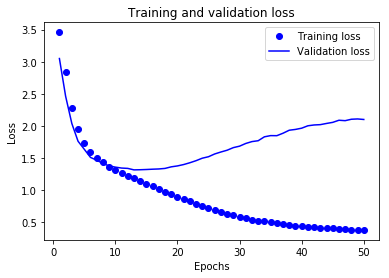

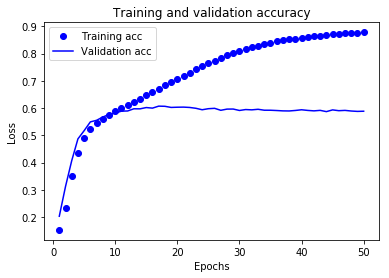

In [21]:
import matplotlib.pyplot as plt
#Validation Graph
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#Accuracy Graph
plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()